# Cluster Tumor Supressors and Oncogenes

In [122]:
import pandas as pd
import os, sys, pickle
import gcnIO
import interpretation_avg
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Times New Roman')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

%matplotlib inline

In [123]:
# parameters
clean = False
lrp_rule = 'elrp'

In [124]:
model_dir = '../data/GCN/training/2018_09_14_14_20_38/'

args, data_file = gcnIO.load_hyper_params(model_dir)
data = gcnIO.load_hdf_data(data_file)
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names = data
print ("Data comes from {}".format(data_file))
print (args)
CLASSIFICATION_THRESHOLD = 0.5
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
nodes.set_index('ID', inplace=True)

Hyper-Parameters read from ../data/GCN/training/2018_09_14_14_20_38/hyper_params.txt
Data comes from ../data/pancancer/iref_multiomics_norm_methnewpromonly_ncglabels.h5
{'lr': 0.001, 'hidden_dims': [50, 40, 30, 20, 10], 'support': 2, 'data': '../data/pancancer/iref_multiomics_norm_methnewpromonly_ncglabels.h5', 'dropout': 0.5, 'cv_runs': 10, 'decay': 0.0005, 'epochs': 7000, 'loss_mul': 30.0}


In [125]:
cancer_gene_list = pd.read_csv('../data/pancancer/vogelstein/table_s2a.csv', sep='\t', header=0)
print ("Got {} cancer genes".format(cancer_gene_list.shape[0]))
cancer_gene_list.columns = [i.strip('*') for i in cancer_gene_list.columns]
cancer_genes = cancer_gene_list[cancer_gene_list['Gene Symbol'].isin(nodes.Name)]
oncogenes = cancer_genes[cancer_genes.Classification == "Oncogene"]
suppressors = cancer_genes[cancer_genes.Classification == "TSG"]
print ("Got {} oncogenes and {} tumour suppressors".format(oncogenes.shape[0], suppressors.shape[0]))

Got 125 cancer genes
Got 52 oncogenes and 71 tumour suppressors


## Compute LRP for genes of interest

In [126]:
pkl_save_path = os.path.join(model_dir, 'onco_sup_{}.pkl'.format(lrp_rule))
if clean or not os.path.exists(pkl_save_path):
    lrp_supressors = interpretation_avg.interpretation_avg(model_dir=model_dir,
                                                          genes=suppressors['Gene Symbol'],
                                                          out_dir=None)
    lrp_oncogenes = interpretation_avg.interpretation_avg(model_dir=model_dir,
                                                          genes=oncogenes['Gene Symbol'],
                                                          out_dir=None)
    with open(pkl_save_path, 'wb') as f:
        pickle.dump(((suppressors['Gene Symbol'], lrp_supressors), (oncogenes['Gene Symbol'], lrp_oncogenes)), f)
else:
    with open(pkl_save_path, 'rb') as f:
        sup, onc = pickle.load(f)
    sup_names, lrp_supressors = sup
    onc_names, lrp_oncogenes = onc

Load: ../data/pancancer/iref_multiomics_norm_methnewpromonly_ncglabels.h5
Calculating Chebyshev polynomials up to order 2...


/project/gcn/diseasegcn/GCN/utils.py:81: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


Now: ACVR1B
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_09_14_14_20_38/cv_0/model.ckpt
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  True
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_09_14_14_20_38/cv_1/model.ckpt
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  True
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_09_14_14_20_38/cv_2/model.ckpt
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  True
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_09_14_14_20_38/cv_3/model.ckpt
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  True
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_09_14_14_20_38/cv_4/model.ckpt
DeepExplain: running "elrp" explanation method (4)
Model with multiple inputs:  True
INFO:tensorflow:Restoring parameters from ../data/GCN/training/2018_

## Get the LRP features to DF

In [127]:
def get_lrp_feature_col(node_names, lrp_list, gene_name):
    idx = np.where(node_names[:, 1] == gene_name)[0]
    return lrp_list.mean(axis=0)[idx].reshape(-1)
    #return lrp_list.mean(axis=0).reshape(-1)
features_sup = []
for gene in range(suppressors.shape[0]):
    lrp_i = get_lrp_feature_col(node_names=node_names,
                                lrp_list=lrp_supressors[gene],
                                gene_name=suppressors['Gene Symbol'].iloc[gene]
                               )
    features_sup.append(lrp_i)

features_onc = []
for gene in range(oncogenes.shape[0]):
    lrp_i = get_lrp_feature_col(node_names=node_names,
                                lrp_list=lrp_oncogenes[gene],
                                gene_name=oncogenes['Gene Symbol'].iloc[gene]
                               )
    features_onc.append(lrp_i)

In [128]:
len(features_sup), len(features_onc)
X_sup = np.array(features_sup)
X_onc = np.array(features_onc)
X = np.concatenate((X_sup, X_onc))
y = np.concatenate((np.zeros(X_sup.shape[0]), np.ones(X_onc.shape[0])))

In [129]:
X_df = pd.DataFrame(X, index=pd.concat((suppressors, oncogenes))['Gene Symbol'])

## Compute Embeddings & Plot

In [130]:
n_comp = 2
type_of_emb = 'TSNE'

if type_of_emb is 'PCA':
    dim_red = PCA(n_components=n_comp)
else:
    dim_red = TSNE(n_components=n_comp)
cols = [col for col in X_df.columns if not type(col) is str]
embedding = dim_red.fit_transform(X_df[cols])

for i in range(n_comp):
    X_df['emb_{}'.format(i)] = embedding[:, i]
X_df['Type'] = np.concatenate((['Tumor_Suppressor']*suppressors.shape[0], ['Oncogene']*oncogenes.shape[0]))

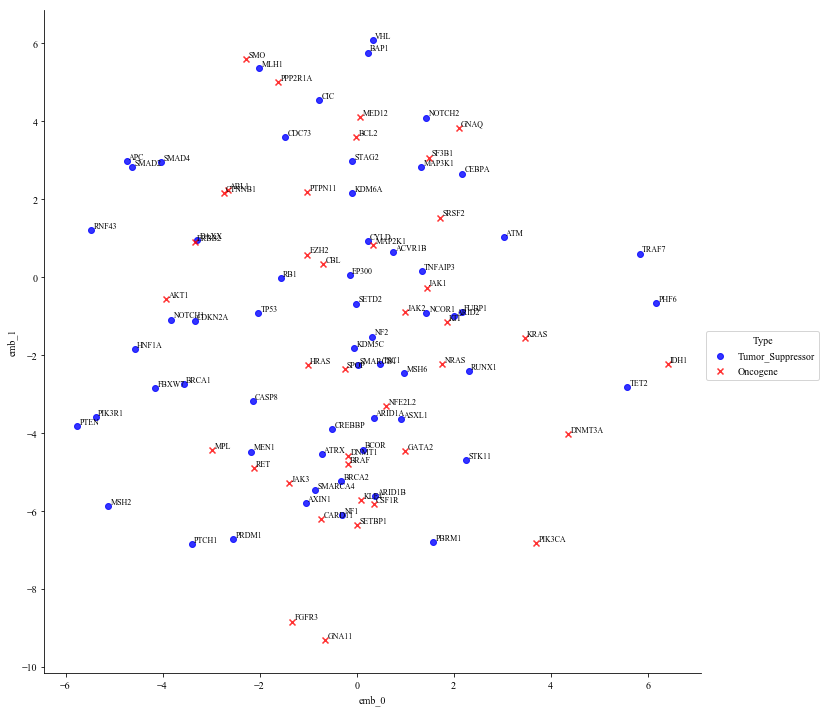

In [131]:
X_df = X_df[(X_df == 0).sum(axis=1) < 10]
fig = plt.figure(figsize=(20, 20))
snsplot = sns.lmplot(data=X_df, x='emb_0', y='emb_1', hue='Type', fit_reg=False, size=10, x_jitter=0.001, y_jitter=0.001, markers=['o', 'x'],
           palette=dict(Tumor_Suppressor="b", Oncogene="r")
          )
#plt.xlim([-2, 3])
#plt.ylim([-3, 3])

for name, col in X_df.iterrows():
    plt.text(x=col.emb_0+.05, y=col.emb_1+.05, s=name, size=8)

snsplot.savefig(os.path.join(model_dir, 'embedding_{}.png'.format(type_of_emb)), dpi=300)
snsplot.savefig(os.path.join(model_dir, 'embedding_{}.svg'.format(type_of_emb)))

## Clustering

In [132]:
from sklearn.cluster import KMeans
cols = [col for col in X_df.columns if not type(col) is str]
pred = KMeans(n_clusters=5).fit_predict(X_df[cols], y)

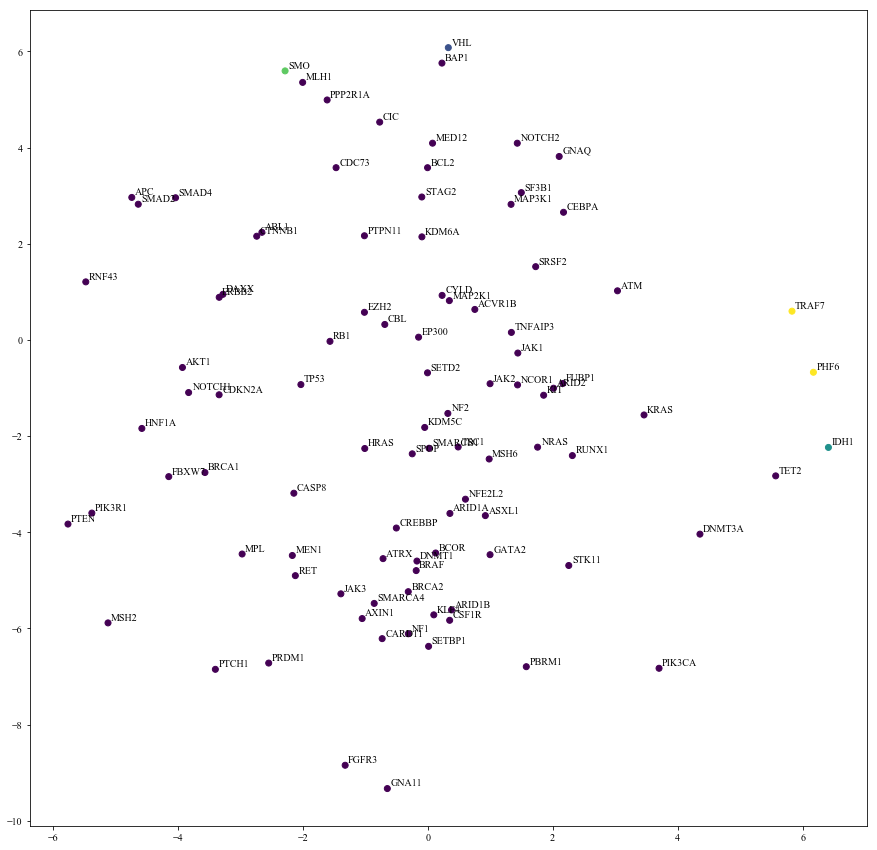

In [133]:
fig = plt.figure(figsize=(15, 15))
plt.scatter(x=X_df.emb_0, y=X_df.emb_1, c=pred)
#plt.xlim([-2, 3])
#plt.ylim([-3, 3])

for name, col in X_df.iterrows():
    plt.text(x=col.emb_0+.05, y=col.emb_1+.05, s=name)

In [134]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Z = linkage(X_df[cols], 'ward')
c, coph_dists = cophenet(Z, pdist(X_df[cols]))
c

0.9825651887367245

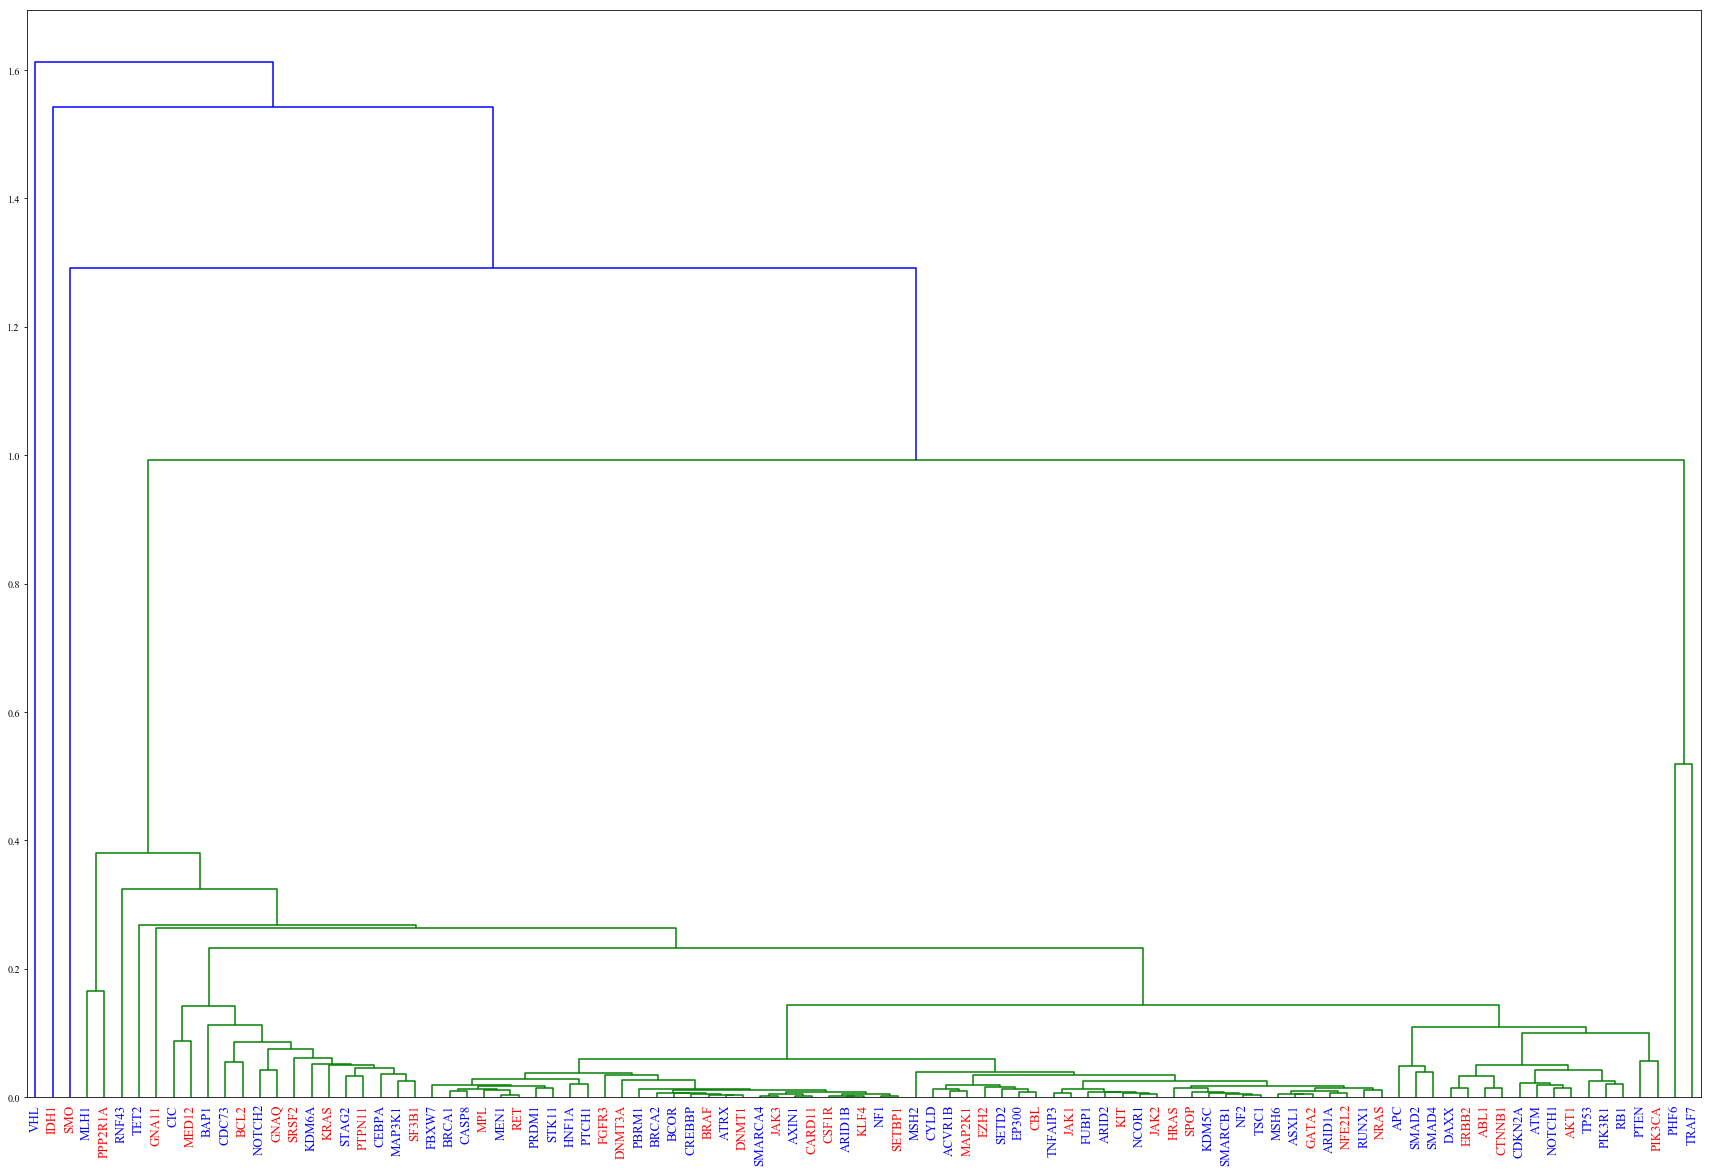

In [135]:
fig = plt.figure(figsize=(30, 20))
_ = dendrogram(Z, leaf_rotation=90, labels=X_df.index, leaf_font_size=13)

# color the leaves according to whether they are oncogenes or TSGs
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    onco = oncogenes['Gene Symbol'].str.contains(lbl.get_text().strip()).any()
    lbl.set_color('red' if onco else 'blue')

fig.savefig(os.path.join(model_dir, 'hierarchical_clustering_oncosupgenes.svg'))
fig.savefig(os.path.join(model_dir, 'hierarchical_clustering_oncosupgenes.png'), dpi=300)

In [136]:
cancers = pd.concat((suppressors, oncogenes))

In [137]:
preds = pd.read_csv(os.path.join(model_dir, 'ensemble_predictions.tsv'), sep='\t')
#preds[preds.Name.isin(cancers['Gene Symbol'])]
preds[preds.Name.isin(['IDH1', 'PHF6', 'FOXL2', 'CRLF2', 'VHL', 'SMO'])]

,ID,label,Name,Prob_pos_1,Prob_pos_2,Prob_pos_3,Prob_pos_4,Prob_pos_5,Prob_pos_6,Prob_pos_7,Prob_pos_8,Prob_pos_9,Prob_pos_10,Num_Pos,Mean_Pred,Std_Pred
1980,ENSG00000134086,True,VHL,0.996,0.992,0.998,0.989,0.944,0.751,0.997,0.999,0.766,0.973,10,0.941,0.097
2799,ENSG00000183770,True,FOXL2,0.862,0.873,0.755,0.852,0.886,0.821,0.819,0.806,0.803,0.774,10,0.825,0.043
4263,ENSG00000205755,True,CRLF2,0.000,0.798,0.602,0.000,0.004,0.865,0.000,0.581,0.007,0.877,5,0.373,0.403
6659,ENSG00000128602,True,SMO,0.059,0.018,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.008,0.019
8287,ENSG00000156531,True,PHF6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,0.000
8714,ENSG00000138413,True,IDH1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,0.000


## Check if the Input Features are Clustering

In [138]:
inp_sup = features[nodes.Name.isin(suppressors['Gene Symbol'])]
inp_onc = features[nodes.Name.isin(oncogenes['Gene Symbol'])]

In [139]:
X_inp = np.concatenate((inp_sup, inp_onc))
y = np.concatenate((np.zeros(inp_sup.shape[0]), np.ones(inp_onc.shape[0])))

In [140]:
if type_of_emb is 'PCA':
    dim_red = PCA(n_components=n_comp)
else:
    dim_red = TSNE(n_components=n_comp)
emb = dim_red.fit_transform(X_inp)
names = pd.concat((suppressors['Gene Symbol'], oncogenes['Gene Symbol']))

(123, 2) (123,)


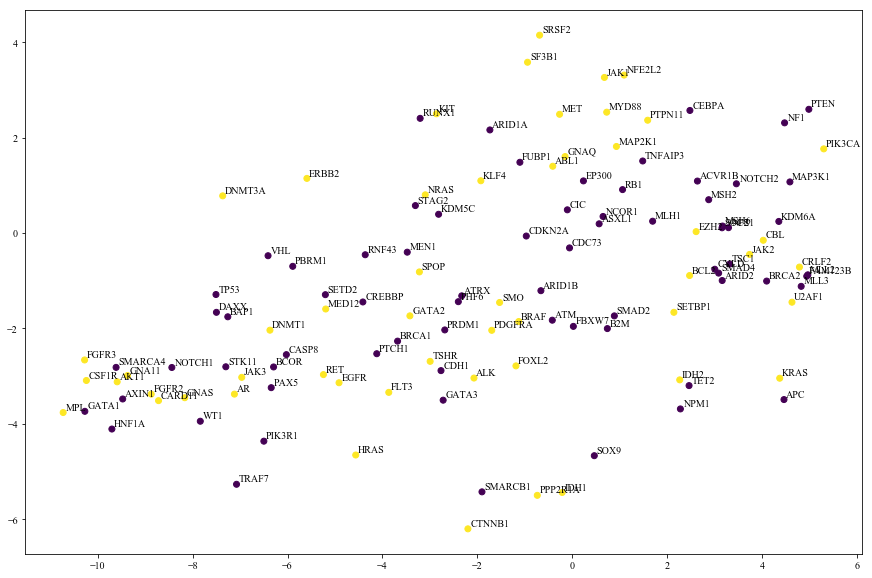

In [141]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(x=emb[:, 0], y=emb[:, 1], c=y)
print (emb.shape, names.shape)
for i in range(len(names)):
    plt.text(x=emb[i, 0]+.05, y=emb[i, 1]+.05, s=names.iloc[i])

0.6135895375716565


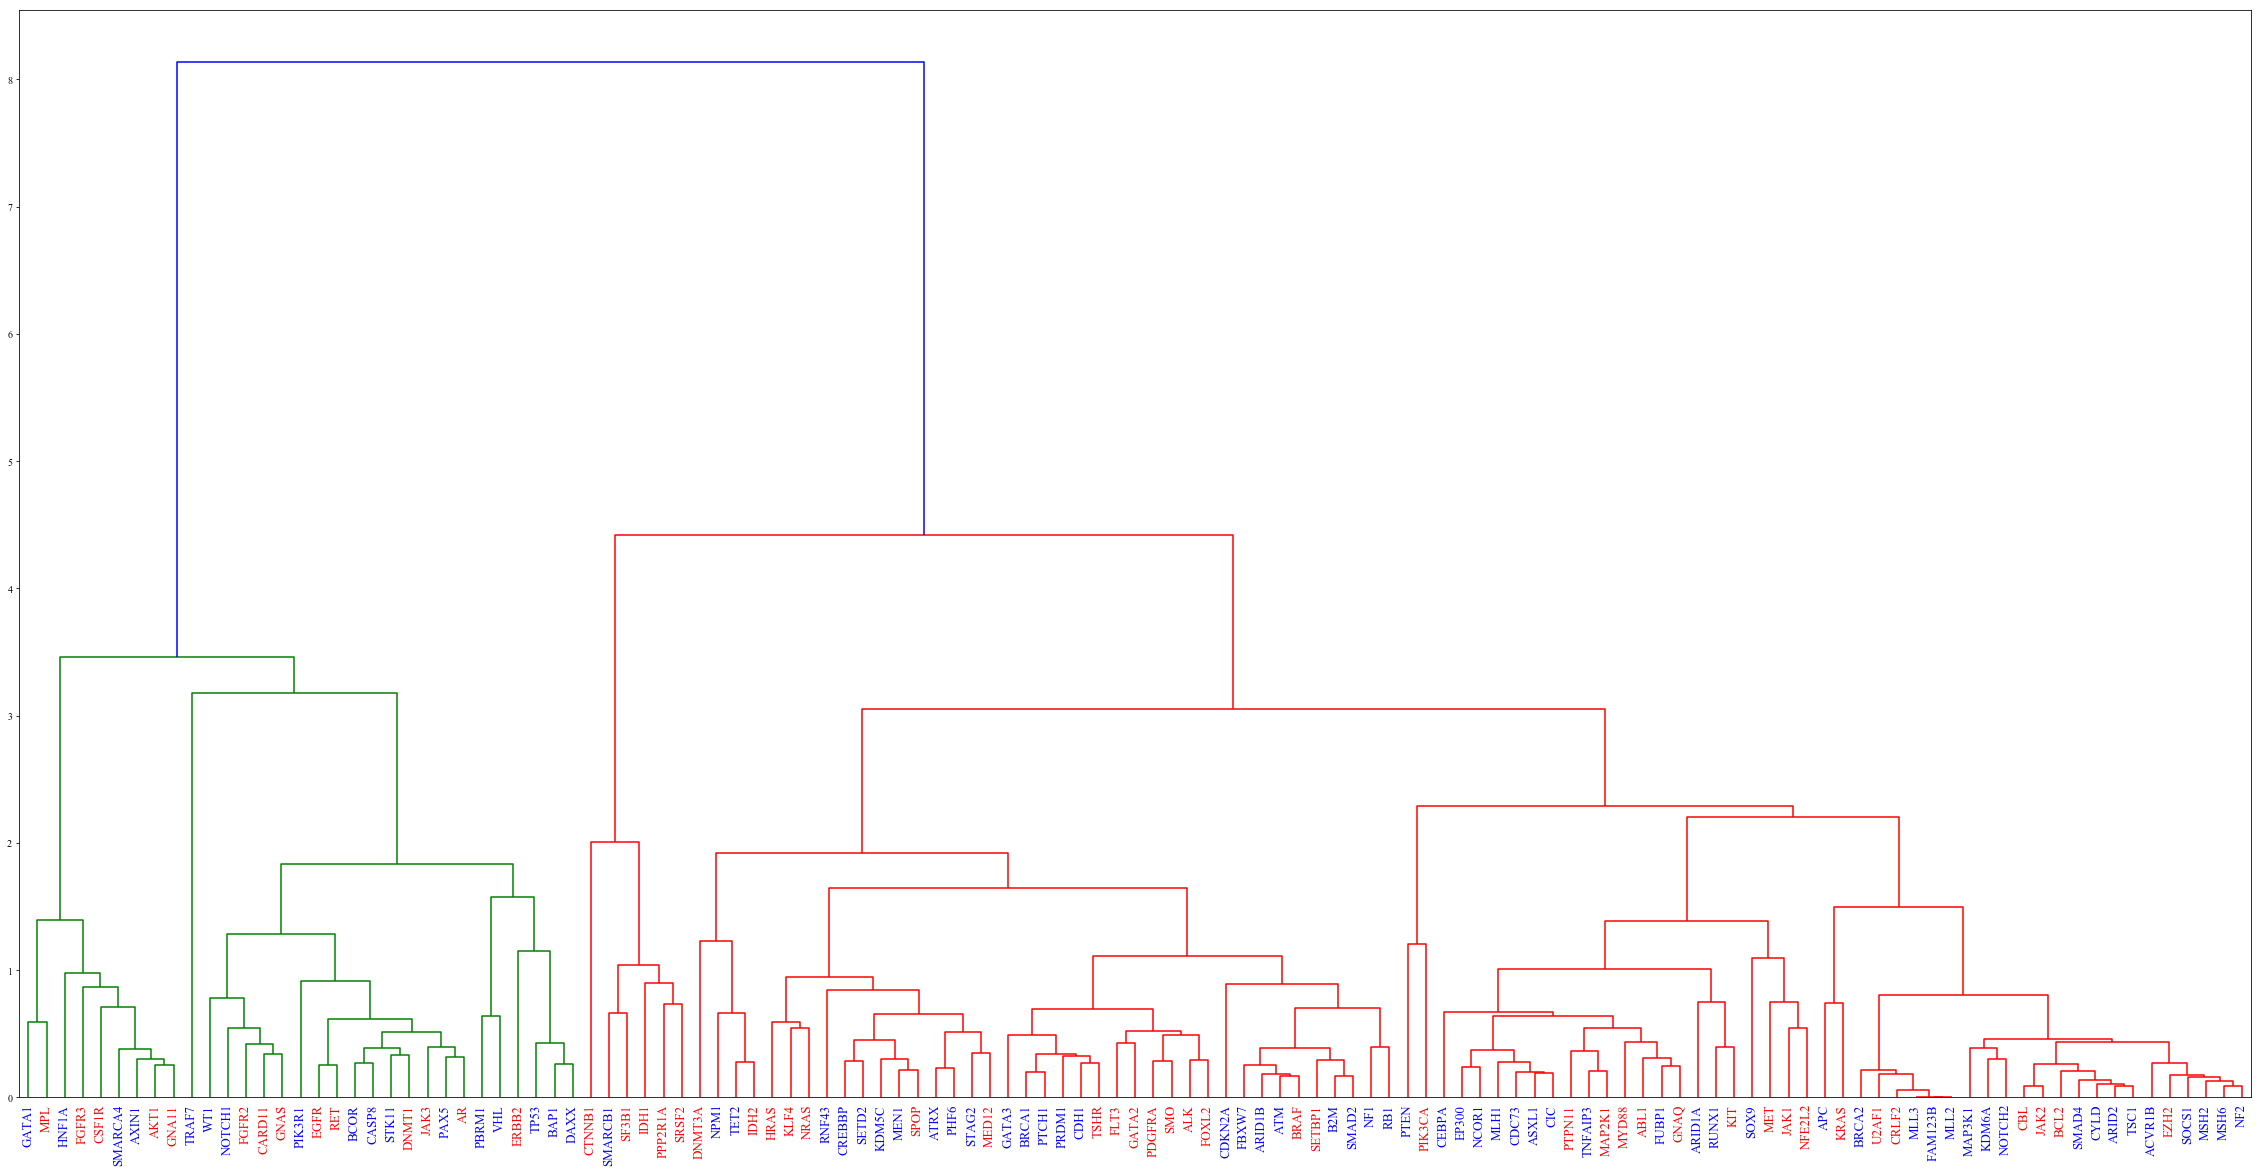

In [142]:
Z_inp = linkage(X_inp, 'ward')
c, coph_dists = cophenet(Z_inp, pdist(X_inp))
print (c)
fig = plt.figure(figsize=(40, 20))
_ = dendrogram(Z_inp, leaf_rotation=90, labels=np.array(names), leaf_font_size=13)

# color the leaves according to whether they are oncogenes or TSGs
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    onco = oncogenes['Gene Symbol'].str.contains(lbl.get_text().strip()).any()
    #print (onco)
    lbl.set_color('red' if onco else 'blue')
fig.savefig(os.path.join(model_dir, 'hierarchical_clustering_oncosupgenes_input.svg'))
fig.savefig(os.path.join(model_dir, 'hierarchical_clustering_oncosupgenes_input.png'), dpi=300)

## Check if suppressors are more methylated than oncogenes

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 'type']


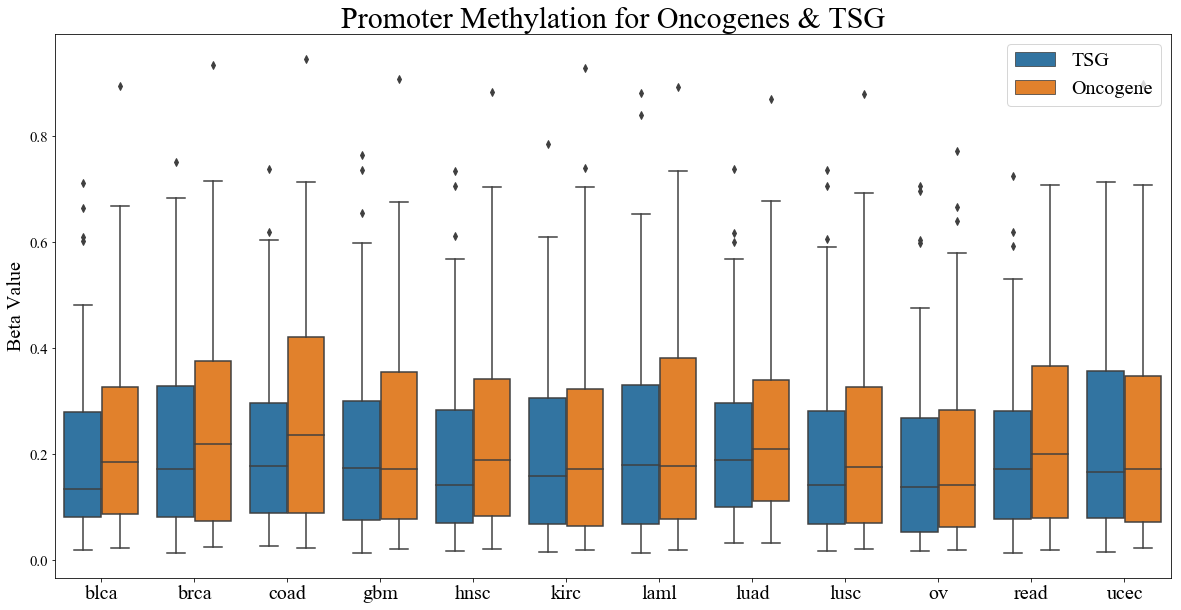

In [143]:
# build feature dataframe
feat_df = pd.DataFrame(X_inp, index=names)
feat_df['type'] = np.array(['TSG']*X_sup.shape[0] + ['Oncogene']*X_onc.shape[0])

# select only promoter methylation
meth_cols = [i for i in range(11, 23)] + ['type']
print (meth_cols)
meth_df = feat_df[meth_cols]
gn = ['TP53', 'SF3B1', 'CASP8', 'CDH1', 'JAK1']
#meth_df = meth_df[meth_df.index.isin(gn)]
meth_df.columns = ['blca', 'brca', 'coad', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'read', 'ucec', 'type']
meth_df = meth_df[(meth_df == 0).sum(axis=1) < 10] # remove genes with no methylation
# plot
fig = plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=pd.melt(meth_df, id_vars=['type']), x='variable', y='value', hue='type', dodge=True)
plt.xlabel('')
plt.ylabel('Beta Value', fontsize=20)
plt.title('Promoter Methylation for Oncogenes & TSG', fontsize=30)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.legend(loc='upper right', fontsize=20)

In [144]:
F = np.load('../data/pancancer/multiomics_features_raw.npy')
feat_raw_meth = F[:, 11:23]
all_meth_raw = pd.DataFrame(feat_raw_meth, index=node_names[:, 1])
all_meth_raw['type'] = 'Other'
all_meth_raw.loc[all_meth_raw.index.isin(suppressors['Gene Symbol']), 'type'] = 'TSG'
all_meth_raw.loc[all_meth_raw.index.isin(oncogenes['Gene Symbol']), 'type'] = 'Oncogene'
all_meth_raw.columns = ['blca', 'brca', 'coad', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'read', 'ucec', 'type']

In [145]:
# build dataframe for all features with type
all_feat = pd.DataFrame(features, index=node_names[:, 1])
all_feat['type'] = 'Other'
all_feat.loc[all_feat.index.isin(suppressors['Gene Symbol']), 'type'] = 'TSG'
all_feat.loc[all_feat.index.isin(oncogenes['Gene Symbol']), 'type'] = 'Oncogene'
all_meth = all_feat[meth_cols]
all_meth.columns = ['blca', 'brca', 'coad', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'read', 'ucec', 'type']

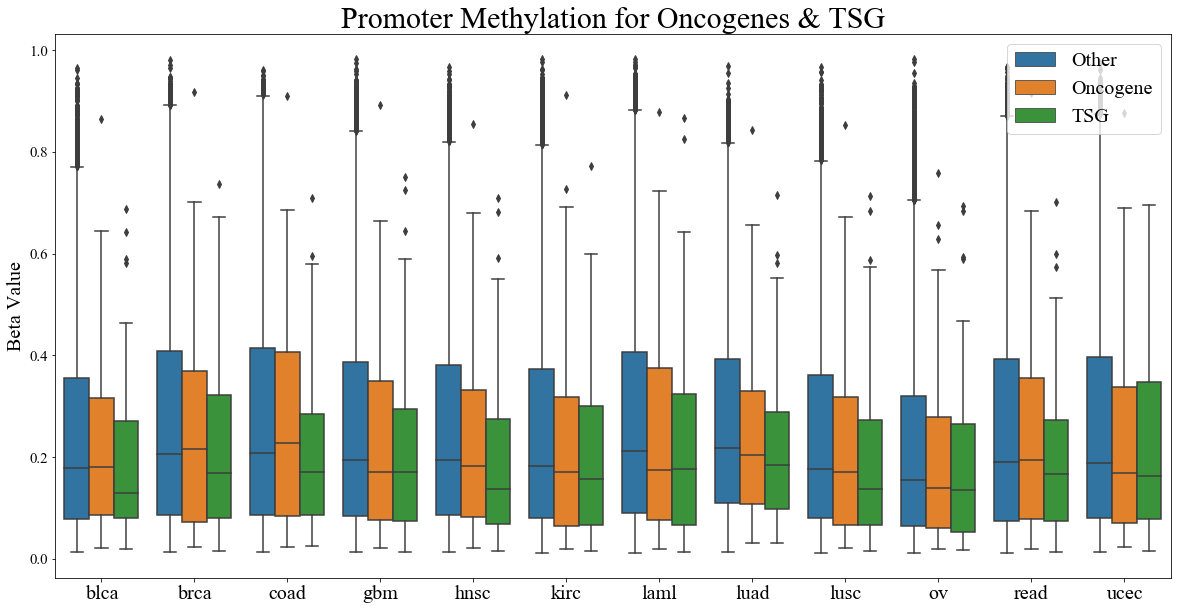

In [146]:
# plot
fig = plt.figure(figsize=(20, 10))
all_meth_raw = all_meth_raw[(all_meth_raw == 0).sum(axis=1) < 10] # remove genes with no methylation
ax = sns.boxplot(data=pd.melt(all_meth_raw, id_vars=['type']), x='variable', y='value', hue='type', dodge=True)
plt.xlabel('')
plt.ylabel('Beta Value', fontsize=20)
plt.title('Promoter Methylation for Oncogenes & TSG', fontsize=30)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.legend(loc='upper right', fontsize=20)

fig.savefig(os.path.join(model_dir, 'methprom_boxplot_onco_vs_tsg_vs_rest.png'), dpi=300)

In [147]:
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
nodes.set_index('ID', inplace=True)

known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name
known_cancer_genes_innet.shape, len(known_cancer_genes)

((640,), 711)

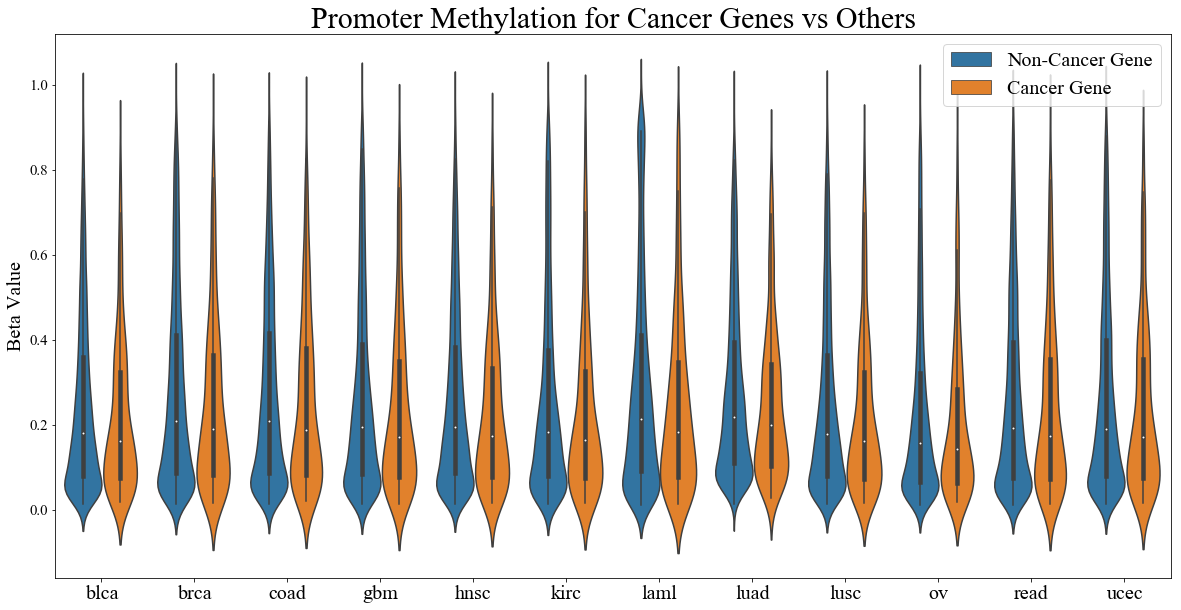

In [148]:
all_meth_raw['label'] = 'Non-Cancer Gene'
all_meth_raw.loc[all_meth_raw.index.isin(known_cancer_genes), 'label'] = 'Cancer Gene'

fig = plt.figure(figsize=(20, 10))
ax = sns.violinplot(data=pd.melt(all_meth_raw.drop('type', axis=1), id_vars=['label']), x='variable', y='value', hue='label', dodge=True)
plt.xlabel('')
plt.ylabel('Beta Value', fontsize=20)
plt.title('Promoter Methylation for Cancer Genes vs Others', fontsize=30)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.legend(loc='upper right', fontsize=20)

In [149]:
all_meth_raw['label'] = 'Non-Cancer Gene'
all_meth_raw.loc[all_meth_raw.index.isin(known_cancer_genes), 'label'] = 'Cancer Gene'

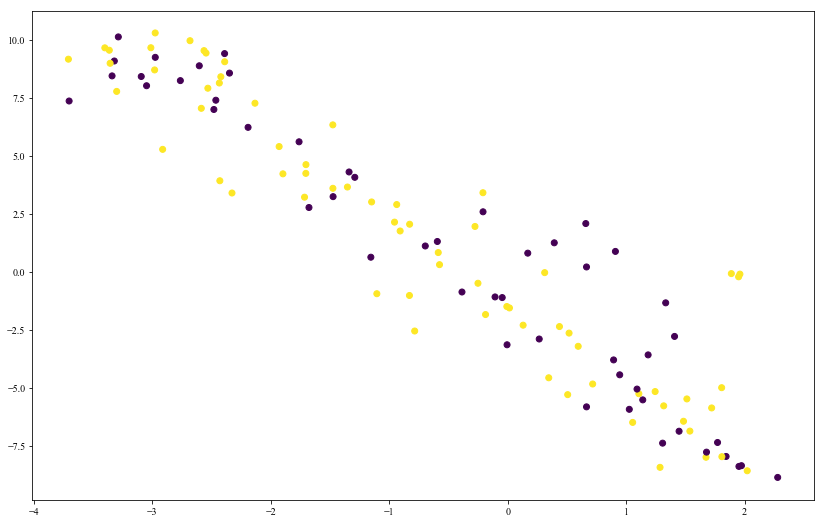

In [150]:
pca = TSNE(n_components=2)
t = all_meth_raw[all_meth_raw.type != 'Other']
e = pca.fit_transform(t.drop(['type', 'label'], axis=1))

fig = plt.figure(figsize=(14, 9))
plt.scatter(e[:, 0], e[:, 1], c=t.type=='TSG')

0.7521137597906272


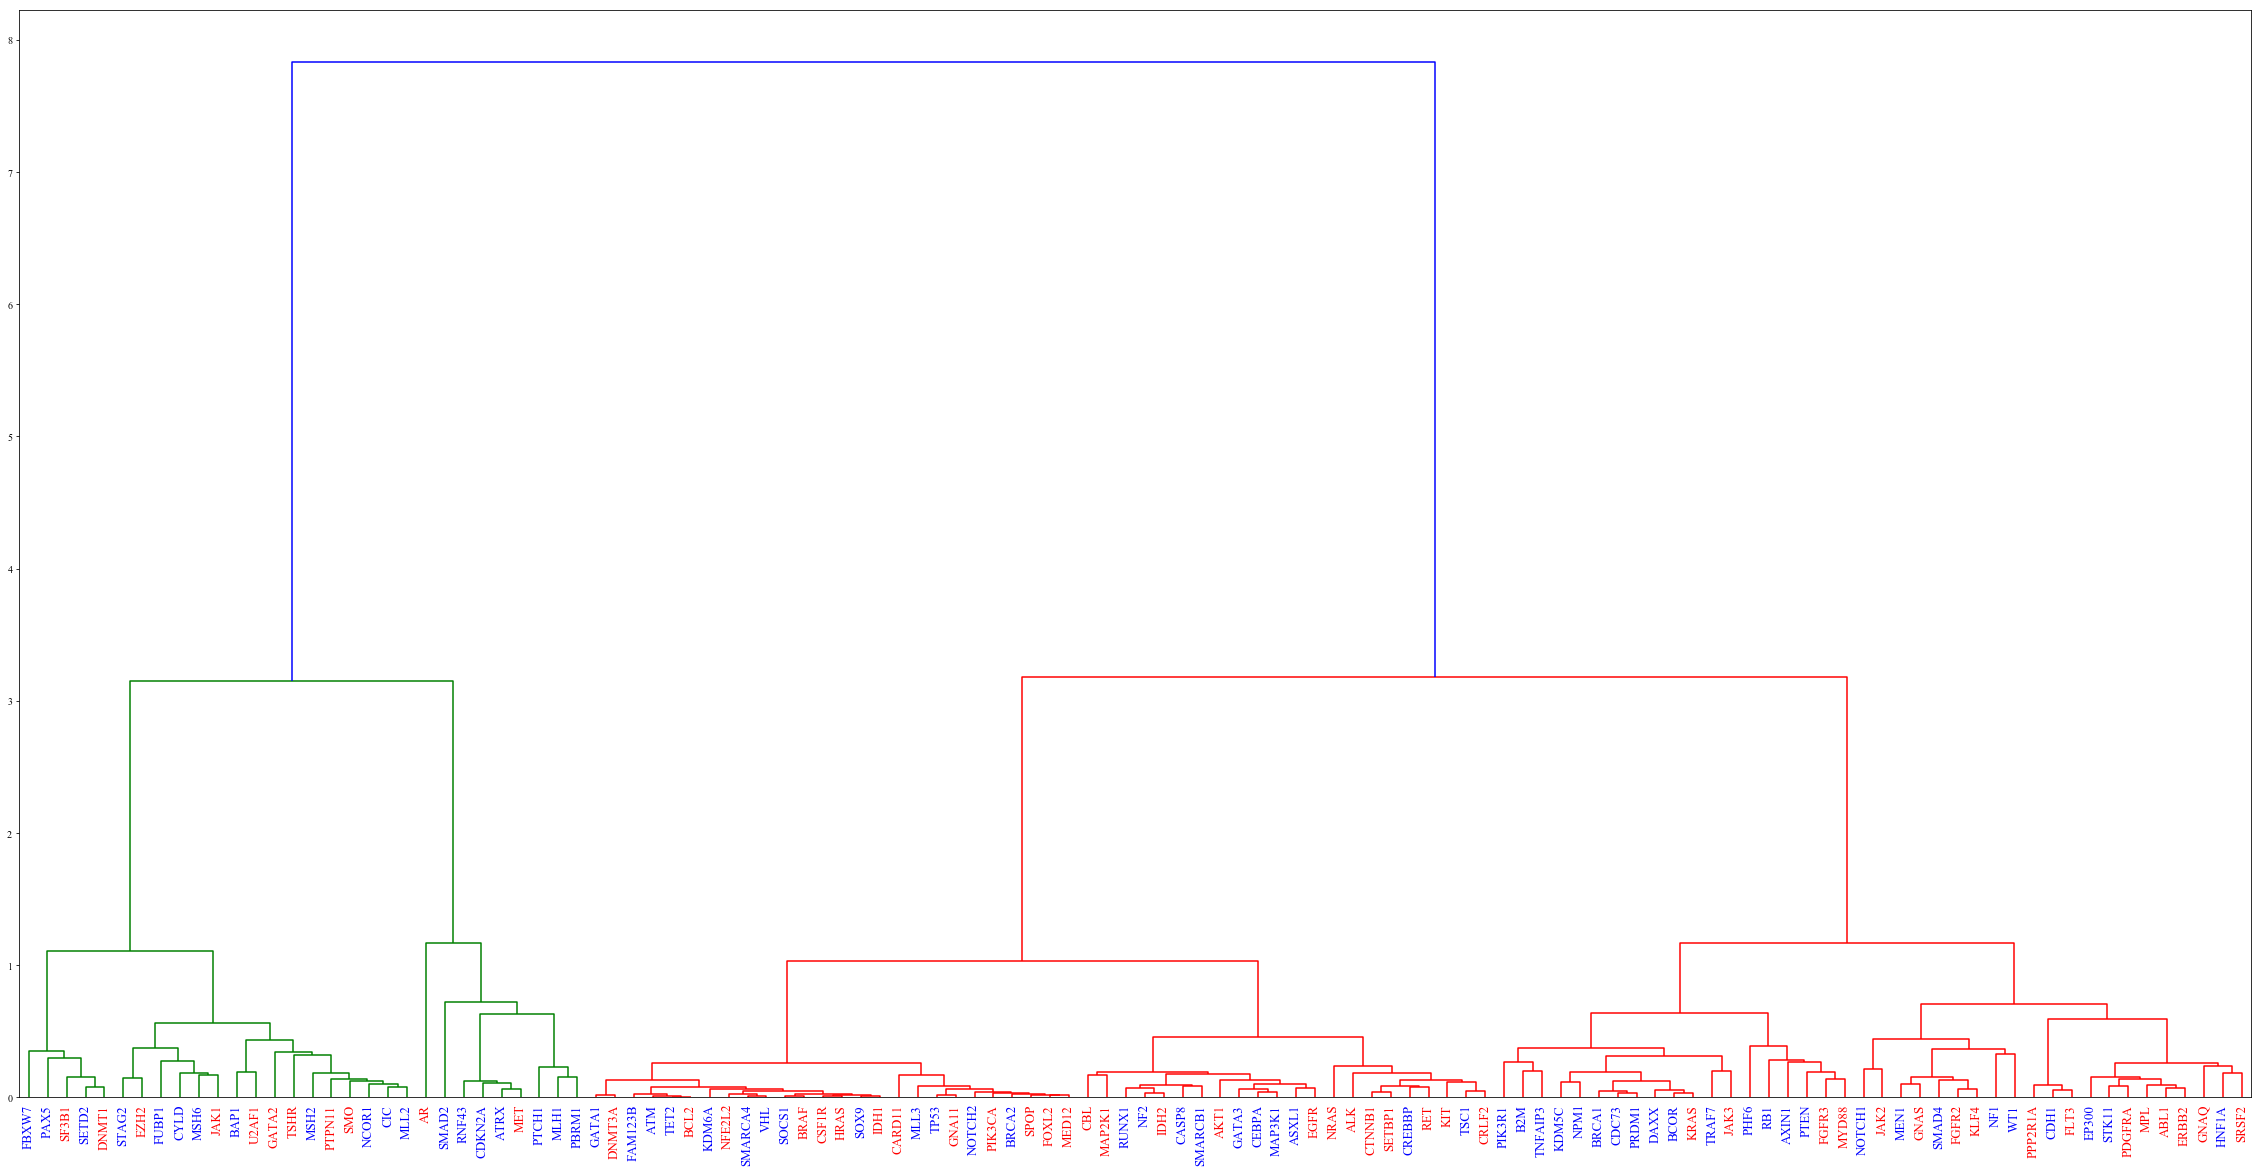

In [151]:
X_raw = t.drop(['type', 'label'], axis=1)
Z_inp = linkage(X_raw, 'ward')
c, coph_dists = cophenet(Z_inp, pdist(X_raw))
print (c)
fig = plt.figure(figsize=(40, 20))
_ = dendrogram(Z_inp, leaf_rotation=90, labels=np.array(names), leaf_font_size=13)

# color the leaves according to whether they are oncogenes or TSGs
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    onco = oncogenes['Gene Symbol'].str.contains(lbl.get_text().strip()).any()
    #print (onco)
    lbl.set_color('red' if onco else 'blue')